# Análisis exploratorio de datos climáticos con Python
## Precipitación y viento – Estación Aeroparque (2002–2022)

**Ubicación:** Estación Meteorológica Aeroparque, Ciudad Autónoma de Buenos Aires (CABA), Argentina.  
**Autor:** Joaquín Llarena (2026)  
**Tipo de proyecto:** Análisis exploratorio y procesamiento de datos climáticos diarios.  
**Fuente de datos:** Servicio Meteorológico Nacional (SMN) – https://ws2.smn.gob.ar/  
**Librerías principales utilizadas:** pandas, numpy y matplotlib.

## 1) Contexto y objetivo

Este proyecto trabaja con datos diarios de precipitación y viento de la Estación Aeroparque (SMN) entre 2002 y 2022.

El objetivo es mostrar un flujo completo de análisis de datos en Python, desde limpieza y transformación hasta exploración y visualización, aplicando buenas prácticas reproducibles.

Se busca un enfoque práctico que permita explorar patrones climáticos y demostrar habilidades de análisis de datos, más que un estudio científico profundo.

Objetivos específicos

- Preparar un dataset limpio y consistente del SMN.

- Explorar la variabilidad estacional e interanual de las variables.

- Identificar eventos de lluvia y viento más intensos.

- Generar métricas e indicadores reproducibles orientados a portfolio de Data Analysis.

## 2) Carga de librerías y configuraciones generales


In [ ]:
# Librerias
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Diccionario de meses
MESES = {
    "Ene": 1, "Feb": 2, "Mar": 3, "Abr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Ago": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dic": 12
}

# Diccionario inverso (para gráficos y tablas)
MESES_NOMBRE = {v: k for k, v in MESES.items()}

In [ ]:
# Funciones auxiliares para parsing de datos meteorológicos


# Estructura de control para recorrer tablas anuales en archivos de texto
def inicializar_estado():
    return {
        "anio_actual": None,
        "encabezado": None,
        "leyendo_tabla": False
    }


# Identificación del encabezado de las tablas
# Devuelve la lista de meses
def detectar_encabezado(linea):
    if linea.startswith("D") and "Ene" in linea and ";" in linea:
        return linea.split(";")[1:-1]
    return None


# Construcción de fechas
# Evita errores por fechas inválidas (por ejemplo, 30 de febrero)
def construir_fecha(anio, mes, dia):
    try:
        return pd.Timestamp(anio, MESES[mes], dia)
    except ValueError:
        return None

## 3) Carga de datos crudos

In [ ]:
# Rutas locales
ruta_ppit = "../data/raw_data/Aeroparque_Precipitaciones.txt"
ruta_viento_medio = "../data/raw_data/Aeroparque_Viento_Medio.txt"
ruta_viento_max = "../data/raw_data/Aeroparque_Viento_Max.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Precipitaciones
with open(ruta_ppit, encoding="latin1") as f:
    raw_text_ppit = f.readlines()

# Viento escalar medio
with open(ruta_viento_medio, encoding="latin1") as f:
    raw_text_viento_medio = f.readlines()

# Viento maximo
with open(ruta_viento_max, encoding="latin1") as f:
    raw_text_viento_max = f.readlines()

## 4) Procesamiento y limpieza de datos


Esta sección contiene la mayor parte del trabajo de preparación de datos del proyecto.


Los archivos del SMN presentan un formato semi-estructurado (texto plano),
lo que requirió el desarrollo de un proceso de parsing personalizado
para extraer fechas y valores diarios de forma consistente y reproducible.

### 4.1 Procesamiento de precipitaciones diarias



Se implementa un proceso de lectura, parsing y limpieza de los registros diarios
de precipitación, transformando los datos crudos en un DataFrame estructurado.

In [ ]:
# Parsing de datos de precipitaciones

datos_ppit = []
estado = inicializar_estado()

for linea in raw_text_ppit:
    linea = linea.strip()

    # Identificación del inicio de una nueva tabla anual
    match = re.search(r"(\d{4})", linea)
    if "Precipitaciones" in linea and match:
        estado["anio_actual"] = int(match.group(1))
        estado["leyendo_tabla"] = False
        continue

    # Detección del encabezado mensual (meses)
    encabezado = detectar_encabezado(linea)
    if encabezado:
        estado["encabezado"] = encabezado
        estado["leyendo_tabla"] = True
        continue

    # Lectura de filas correspondientes a días del mes
    if estado["leyendo_tabla"] and re.match(r"^\d{1,2};", linea):
        partes = linea.split(";")
        dia = int(partes[0])

        for mes, valor in zip(estado["encabezado"], partes[1:-1]):

            # Normalización de valores faltantes o sin precipitación
            if valor in ["S/P", ""]:
                precip = 0.0
            else:
                precip = float(valor.replace(",", ".").replace("<", ""))

            fecha = construir_fecha(estado["anio_actual"], mes, dia)
            if fecha is None:
                continue

            datos_ppit.append({
                "fecha": fecha,
                "precipitacion_mm": precip
            })

Construcción del DataFrame

In [ ]:
df_ppit = pd.DataFrame(datos_ppit).sort_values("fecha").reset_index(drop=True)
df_ppit.head()

,fecha,precipitacion_mm
0,2002-01-01,0.0
1,2002-01-02,0.0
2,2002-01-03,0.0
3,2002-01-04,70.0
4,2002-01-05,42.0


In [ ]:
df_ppit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             7670 non-null   datetime64[ns]
 1   precipitacion_mm  7670 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 120.0 KB


### 4.2 Procesamiento del viento escalar medio


Se aplica un proceso de parsing y limpieza similar al utilizado
para precipitaciones, adaptado a la estructura específica
de los registros de viento escalar medio.

In [ ]:
# Parsing de datos de viento escalar medio diario

datos_viento_medio = []
estado = inicializar_estado()

for linea in raw_text_viento_medio:
    linea = linea.strip()

    # Identificación del inicio de una nueva tabla anual
    match = re.search(r"(\d{4})", linea)
    if "Viento Escalar" in linea and match:
        estado["anio_actual"] = int(match.group(1))
        estado["leyendo_tabla"] = False
        continue

    # Detección del encabezado mensual (meses)
    encabezado = detectar_encabezado(linea)
    if encabezado:
        estado["encabezado"] = encabezado
        estado["leyendo_tabla"] = True
        continue

    # Lectura de registros diarios dentro de la tabla
    if estado["leyendo_tabla"] and re.match(r"^\d{1,2};", linea):
        partes = linea.split(";")
        dia = int(partes[0])

        for mes, valor in zip(estado["encabezado"], partes[1:-1]):

            # Se omiten valores faltantes
            if valor == "":
                continue

            try:
                viento = float(valor.replace(",", "."))
            except ValueError:
                continue

            fecha = construir_fecha(estado["anio_actual"], mes, dia)
            if fecha is None:
                continue

            datos_viento_medio.append({
                "fecha": fecha,
                "viento_escalar_medio_kmh": viento
            })

Construcción del DataFrame

In [ ]:
df_viento_medio = pd.DataFrame(datos_viento_medio).sort_values("fecha").reset_index(drop=True)
df_viento_medio.head()

,fecha,viento_escalar_medio_kmh
0,2002-01-01,15.0
1,2002-01-02,12.0
2,2002-01-03,12.0
3,2002-01-04,26.0
4,2002-01-05,31.0


In [ ]:
df_viento_medio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha                     7670 non-null   datetime64[ns]
 1   viento_escalar_medio_kmh  7670 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 120.0 KB


### 4.3 Procesamiento del viento maximo



Se aplica un proceso de parsing y limpieza similar al utilizado en los casos anteriores,
adaptado a la estructura específica de los registros de viento máximo,
que incluyen tanto la magnitud como la dirección del viento.

In [ ]:
# Parsing de datos de viento máximo diario (dirección + magnitud)

datos_viento_max = []
estado = inicializar_estado()

for linea in raw_text_viento_max:
    linea = linea.strip()

    # Identificación del inicio de una nueva tabla anual
    match = re.search(r"(\d{4})", linea)
    if "Viento" in linea and match:
        estado["anio_actual"] = int(match.group(1))
        estado["leyendo_tabla"] = False
        continue

    # Detección del encabezado mensual (meses)
    encabezado = detectar_encabezado(linea)
    if encabezado:
        estado["encabezado"] = encabezado
        estado["leyendo_tabla"] = True
        continue

    # Lectura de registros diarios y separación de dirección y velocidad
    if estado["leyendo_tabla"] and re.match(r"^\d{1,2};", linea):
        partes = linea.split(";")
        dia = int(partes[0])

        for mes, valor in zip(estado["encabezado"], partes[1:-1]):

            # Se omiten celdas sin información
            if valor == "":
                continue

            # Formato esperado: "<dirección> <velocidad>"
            partes_viento = valor.split()
            if len(partes_viento) != 2:
                continue

            direccion = partes_viento[0]

            try:
                velocidad = float(partes_viento[1].replace(",", "."))
            except ValueError:
                continue

            fecha = construir_fecha(estado["anio_actual"], mes, dia)
            if fecha is None:
                continue

            datos_viento_max.append({
                "fecha": fecha,
                "direccion_viento": direccion,
                "viento_max_kmh": velocidad
            })

Construcción del DataFrame

In [ ]:
df_viento_max = pd.DataFrame(datos_viento_max).sort_values("fecha").reset_index(drop=True)
df_viento_max.head()

,fecha,direccion_viento,viento_max_kmh
0,2002-01-01,Sur,37.0
1,2002-01-02,Este,33.0
2,2002-01-03,Oeste,52.0
3,2002-01-04,Este,54.0
4,2002-01-05,Sudeste,63.0


In [ ]:
df_viento_max.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             7670 non-null   datetime64[ns]
 1   direccion_viento  7670 non-null   object        
 2   viento_max_kmh    7670 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 179.9+ KB


## 5) Construcción del dataset climático final

Las variables climáticas fueron procesadas por separado debido a diferencias
en el formato de los archivos originales.  
Una vez procesados los datos, se integran en un único DataFrame temporal, permitiendo analizar las variables de forma conjunta.

In [ ]:
# Junto los 3 dataframes

df_clima = (
    df_ppit
    .merge(df_viento_medio, on="fecha", how="left")
    .merge(df_viento_max, on="fecha", how="left")
)

df_clima = df_clima.sort_values("fecha").reset_index(drop=True)

# Agrego columnas adicionales de mes y año

df_clima["anio"] = df_clima["fecha"].dt.year
df_clima["mes"] = df_clima["fecha"].dt.month

df_clima.head()

,fecha,precipitacion_mm,viento_escalar_medio_kmh,direccion_viento,viento_max_kmh,anio,mes
0,2002-01-01,0.0,15.0,Sur,37.0,2002,1
1,2002-01-02,0.0,12.0,Este,33.0,2002,1
2,2002-01-03,0.0,12.0,Oeste,52.0,2002,1
3,2002-01-04,70.0,26.0,Este,54.0,2002,1
4,2002-01-05,42.0,31.0,Sudeste,63.0,2002,1


La unificación de los datos se realizó mediante un `left join`,
utilizando la serie de precipitaciones como referencia temporal.
De este modo se preservan todos los días con registro de lluvia,
aun cuando no existan datos de viento para esa fecha.

In [ ]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha                     7670 non-null   datetime64[ns]
 1   precipitacion_mm          7670 non-null   float64       
 2   viento_escalar_medio_kmh  7670 non-null   float64       
 3   direccion_viento          7670 non-null   object        
 4   viento_max_kmh            7670 non-null   float64       
 5   anio                      7670 non-null   int32         
 6   mes                       7670 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(2), object(1)
memory usage: 359.7+ KB


In [ ]:
# Reviso valores nulos

df_clima.isna().sum()

,0
fecha,0
precipitacion_mm,0
viento_escalar_medio_kmh,0
direccion_viento,0
viento_max_kmh,0
anio,0
mes,0


In [ ]:
# Chequeo de fechas

fechas_esperadas = pd.date_range(
    start=df_clima["fecha"].min(),
    end=df_clima["fecha"].max(),
    freq="D"
)

fechas_faltantes = fechas_esperadas.difference(df_clima["fecha"])

len(fechas_faltantes)

0

A partir de este punto se trabajará exclusivamente con el DataFrame `df_clima`,
que contiene las variables climáticas diarias unificadas y validadas.
Las etapas siguientes corresponden al análisis exploratorio de datos (EDA).

## 6) Análisis Exploratorio de Datos (EDA)

En esta sección se realiza un análisis exploratorio de los datos integrados,
con el objetivo de identificar patrones temporales, variabilidad,
tendencias generales y eventos relevantes.

### 6.1 Caracterización general del dataset

Se presenta un resumen del dataset final: variables disponibles, tipo de datos y período temporal analizado.

In [ ]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha                     7670 non-null   datetime64[ns]
 1   precipitacion_mm          7670 non-null   float64       
 2   viento_escalar_medio_kmh  7670 non-null   float64       
 3   direccion_viento          7670 non-null   object        
 4   viento_max_kmh            7670 non-null   float64       
 5   anio                      7670 non-null   int32         
 6   mes                       7670 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(2), object(1)
memory usage: 359.7+ KB


In [ ]:
fecha_min = df_clima["fecha"].min()
fecha_max = df_clima["fecha"].max()

print(f"Período analizado: {fecha_min.date()} a {fecha_max.date()}")

Período analizado: 2002-01-01 a 2022-12-31


### 6.2 Análisis exploratorio de precipitaciones

En esta sección se analiza el comportamiento de la precipitación registrada en la estación Aeroparque durante el período de estudio. El análisis comienza con una caracterización de la variabilidad mensual y anual de la precipitación y la frecuencia de días con lluvia, y continúa con la evaluación de los eventos extremos de precipitación y su relación con el tipo de año (seco, normal o húmedo).

#### 6.2.1 Caracterización mensual de la precipitación

Para identificar patrones estacionales en la precipitación, se calcula la media mensual de la precipitación y la frecuencia media de días con lluvia durante el período analizado.

In [ ]:
# Cálculo de la precipitación total mensual

ppit_mensual_anual = (
    df_clima
    .groupby(["anio", "mes"])["precipitacion_mm"]
    .sum()
)

In [ ]:
# Cálculo de la precipitación media mensual

ppit_media_mensual = (
    ppit_mensual_anual
    .groupby("mes")
    .mean()
    .round(1)
)

In [ ]:
# Cálculo de días con precipitación por mes

# Nueva columna del df, si es un dia de lluvia o no.

df_clima["dia_lluvia"] = (df_clima["precipitacion_mm"] > 0).astype(int) # Columna binaria: 1 si llovió, 0 si no

# Dias de lluvia por mes

dias_lluvia_mensual_anual = (
    df_clima
    .groupby(["anio", "mes"])["dia_lluvia"]
    .sum()
)

In [ ]:
# Cálculo de la media mensual de días con lluvia

dias_lluvia_media_mensual = (
    dias_lluvia_mensual_anual
    .groupby("mes")
    .mean()
    .round(0)
)

In [ ]:
# Tabla resumen mensual

tabla_mensual = pd.DataFrame({
    "Precipitación media (mm)": ppit_media_mensual,
    "Días de lluvia (media)": dias_lluvia_media_mensual
})

# Agrego nombres de meses
tabla_mensual.index = tabla_mensual.index.map(MESES_NOMBRE)


tabla_mensual = tabla_mensual.T
tabla_mensual

mes,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
Precipitación media (mm),121.4,123.7,109.6,98.9,72.4,45.3,68.6,58.8,83.2,95.0,103.3,99.2
Días de lluvia (media),10.0,10.0,10.0,9.0,8.0,8.0,10.0,9.0,9.0,12.0,9.0,10.0


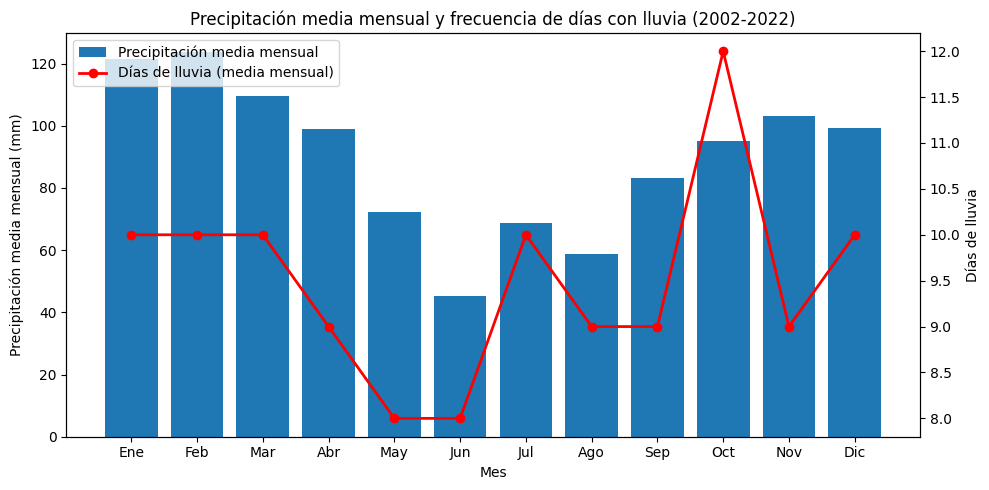

In [ ]:
# Grafico

fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras: precipitación media mensual
barras = ax1.bar(
    ppit_media_mensual.index,
    ppit_media_mensual.values,
    label="Precipitación media mensual",
    zorder=1
)
ax1.set_xlabel("Mes")
ax1.set_ylabel("Precipitación media mensual (mm)")

# Eje X con nombres de meses
ax1.set_xticks(ppit_media_mensual.index)
ax1.set_xticklabels(
    [MESES_NOMBRE[m] for m in ppit_media_mensual.index]
)

# Línea: media de días de lluvia
ax2 = ax1.twinx()
linea, = ax2.plot(
    dias_lluvia_media_mensual.index,
    dias_lluvia_media_mensual.values,
    color="red",
    marker="o",
    linewidth=2,
    label="Días de lluvia (media mensual)",
    zorder=3
)
ax2.set_ylabel("Días de lluvia")

# Leyenda combinada
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="upper left"
)

plt.title("Precipitación media mensual y frecuencia de días con lluvia (2002-2022)")
plt.tight_layout()
plt.show()

La precipitación media mensual presenta una marcada estacionalidad a lo largo del año, con mayores acumulados durante el verano y menores valores en los meses invernales. Los máximos se concentran principalmente entre enero, febrero y marzo, mientras que junio, julio y agosto registran las precipitaciones más bajas del período analizado.

Se observa que los meses con mayor acumulación mensual no siempre coinciden con aquellos con mayor cantidad de días lluviosos, lo que sugiere variaciones en la intensidad de los eventos de precipitación.

#### 6.2.2 Variabilidad interanual de la precipitación

En esta sección se analiza la precipitación anual acumulada, con el objetivo de evaluar su variabilidad interanual, identificar años húmedos y secos, y analizar posibles tendencias a lo largo del período estudiado.

In [ ]:
# Calculo la precipitacion anual acumulada

ppit_anual = (
    df_clima
    .groupby("anio")["precipitacion_mm"]
    .sum()
    .round(1)
)

In [ ]:
# Precipitacion media anual para el periodo (2002-2022)

ppit_media_anual = round(ppit_anual.mean(), 1)

In [ ]:
# Tendencia. Regresión lineal simple
# Ajuste lineal: y = m*x + b

anios = ppit_anual.index.values

pendiente, intercepto = np.polyfit(anios, ppit_anual.values, 1)
pendiente_red = round(pendiente, 1)

print(f"Tendencia lineal: {pendiente_red} mm/año")

# Valores de la tendencia
ppit_tendencia = pendiente * ppit_anual.index.values + intercepto

Tendencia lineal: -4.9 mm/año


In [ ]:
# Armo un DataFrame anual
df_anual = pd.DataFrame({
    "anio": anios,
    "ppit_anual": ppit_anual
})

# Defino los umbrales (±10 %) para años humedos, normales y secos
umbral_humedo = ppit_media_anual * 1.10
umbral_seco = ppit_media_anual * 0.90

# Clasifico los años
df_anual["clasificacion"] = "Normal"
df_anual.loc[df_anual["ppit_anual"] >= umbral_humedo, "clasificacion"] = "Húmedo"
df_anual.loc[df_anual["ppit_anual"] <= umbral_seco, "clasificacion"] = "Seco"

# Extraigo los años humedos y secos
anios_humedos = df_anual.loc[df_anual["clasificacion"] == "Húmedo", "anio"].tolist()
ppit_humedos = df_anual.loc[df_anual["clasificacion"] == "Húmedo", "ppit_anual"].tolist()

anios_secos = df_anual.loc[df_anual["clasificacion"] == "Seco", "anio"].tolist()
ppit_secos = df_anual.loc[df_anual["clasificacion"] == "Seco", "ppit_anual"].tolist()

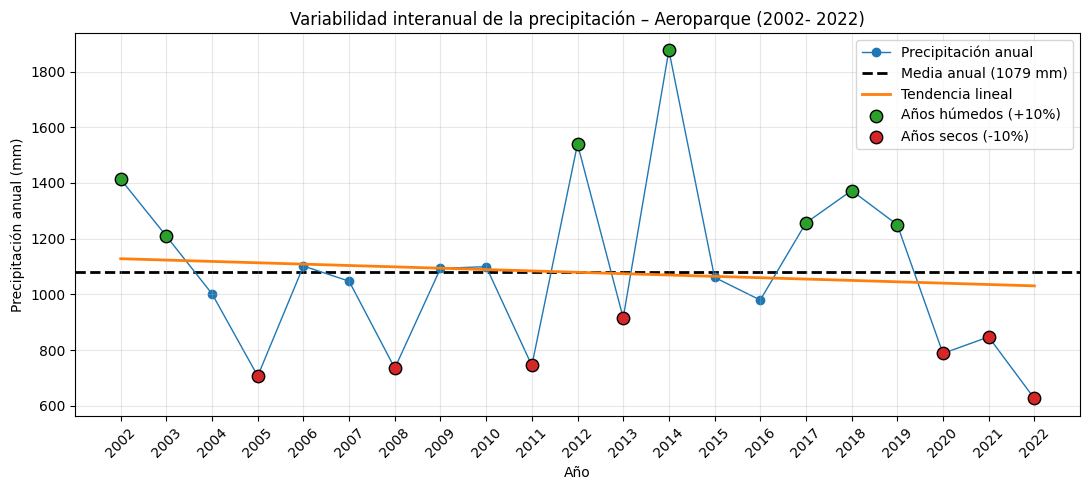

In [ ]:
# Grafico

plt.figure(figsize=(11, 5))

# Precipitación anual (Linea y puntos)
plt.plot(
    anios,
    ppit_anual,
    marker="o",
    linewidth=1,
    color="tab:blue",
    label="Precipitación anual",
    zorder=1
)

# Media anual (Linea punteada)
plt.axhline(
    ppit_media_anual,
    linestyle="--",
    linewidth=2,
    color="black",
    label=f"Media anual ({ppit_media_anual:.0f} mm)",
    zorder=0
)

# Tendencia (Linea naranja)
plt.plot(
    anios,
    ppit_tendencia,
    linewidth=2,
    color="tab:orange",
    label="Tendencia lineal",
    zorder=2
)

# Años húmedos (Puntos verdes)
plt.scatter(
    anios_humedos,
    ppit_humedos,
    color="tab:green",
    edgecolor="black",
    s=80,
    label="Años húmedos (+10%)",
    zorder=3
)

# Años secos (Puntos rojos)
plt.scatter(
    anios_secos,
    ppit_secos,
    color="tab:red",
    edgecolor="black",
    s=80,
    label="Años secos (-10%)",
    zorder=3
)

plt.xlabel("Año")
plt.ylabel("Precipitación anual (mm)")
plt.title("Variabilidad interanual de la precipitación – Aeroparque (2002- 2022)")

plt.xticks(anios, rotation=45)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

La figura muestra la precipitación anual acumulada para el período 2002–2022, junto con su promedio anual de 1079 mm. Se observa una clara variabilidad interanual, con alternancia entre años más húmedos y más secos, destacándose el máximo de 2014 y el mínimo de 2022.

La tendencia lineal sugiere un ligero descenso general hacia condiciones más secas, aunque la variabilidad interanual sigue siendo la característica dominante de la serie. Este patrón permite identificar períodos húmedos y secos y aporta contexto climático relevante para el análisis de la región.



#### 6.2.3 Valores máximos de precipitación diaria y mensual

Se analizan los valores máximos diarios y mensuales de precipitación para identificar eventos de alta magnitud dentro del período estudiado.

In [ ]:
# Maximo valor diario de precipitacion registrado para cada mes calendario

dia_mas_lluvioso_por_mes = (
    df_clima
    .loc[df_clima["precipitacion_mm"] > 0]
    .sort_values("precipitacion_mm", ascending=False)
    .groupby("mes")
    .first()
    .sort_index()
)

# Agrego el nombre del mes
dia_mas_lluvioso_por_mes["mes_nombre"] = (
    dia_mas_lluvioso_por_mes.index.map(MESES_NOMBRE)
)

In [ ]:
# Mes más lluvioso (acumulado mensual) para cada mes calendario

mes_mas_lluvioso_por_mes = (
    ppit_mensual_anual
    .reset_index()
    .sort_values("precipitacion_mm", ascending=False)
    .groupby("mes")
    .first()
    .sort_index()
)

# Agrego el nombre del mes
mes_mas_lluvioso_por_mes["mes_nombre"] = (
    mes_mas_lluvioso_por_mes.index.map(MESES_NOMBRE)
)

In [ ]:
# Tabla resumen

tabla_maximos = pd.DataFrame({
    "Mes": mes_mas_lluvioso_por_mes["mes_nombre"].values,
    "Media mensual (mm)": ppit_media_mensual.values,
    "Máximo mensual registrado (mm)": mes_mas_lluvioso_por_mes["precipitacion_mm"].values,
    "Día más lluvioso (fecha)": dia_mas_lluvioso_por_mes["fecha"].dt.strftime("%d-%m-%Y").values,
    "Precipitación del día más lluvioso (mm)": dia_mas_lluvioso_por_mes["precipitacion_mm"].values
})

tabla_maximos_T = tabla_maximos.set_index("Mes").T
tabla_maximos_T

Mes,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
Media mensual (mm),121.4,123.7,109.6,98.9,72.4,45.3,68.6,58.8,83.2,95.0,103.3,99.2
Máximo mensual registrado (mm),285.7,286.5,289.3,234.9,184.6,204.4,142.8,235.2,209.3,266.8,224.0,284.4
Día más lluvioso (fecha),30-01-2004,01-02-2012,02-03-2008,28-04-2018,07-05-2017,17-06-2019,21-07-2009,18-08-2002,06-09-2013,28-10-2012,29-11-2008,06-12-2012
Precipitación del día más lluvioso (mm),131.0,89.0,81.0,107.0,94.0,64.0,66.0,84.0,80.0,105.0,105.0,150.0


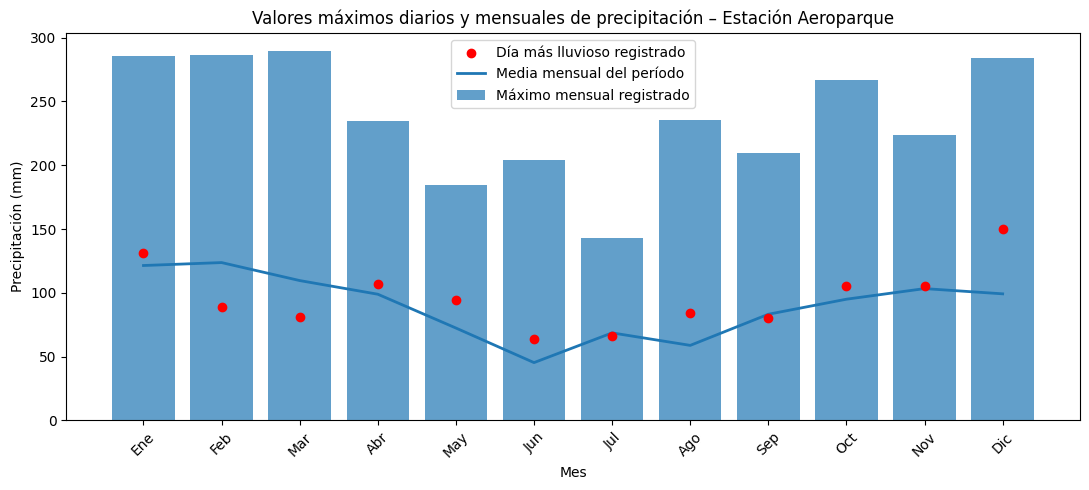

In [ ]:
# Grafico

plt.figure(figsize=(11, 5))

# Barras: mes más lluvioso registrado
plt.bar(
    mes_mas_lluvioso_por_mes["mes_nombre"],
    mes_mas_lluvioso_por_mes["precipitacion_mm"],
    alpha=0.7,
    label="Máximo mensual registrado"
)

# Puntos: día más lluvioso por mes
plt.scatter(
    dia_mas_lluvioso_por_mes["mes_nombre"],
    dia_mas_lluvioso_por_mes["precipitacion_mm"],
    color="red",
    zorder=3,
    label="Día más lluvioso registrado"
)

# Línea: media mensual
plt.plot(
    mes_mas_lluvioso_por_mes["mes_nombre"],
    ppit_media_mensual.values,
    linewidth=2,
    label="Media mensual del período"
)

plt.xlabel("Mes")
plt.ylabel("Precipitación (mm)")
plt.title("Valores máximos diarios y mensuales de precipitación – Estación Aeroparque")

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La figura muestra, para cada mes calendario, los máximos acumulados mensuales, los valores máximos diarios y la precipitación media mensual. Esto permite comparar los eventos extremos con el comportamiento promedio del régimen pluviométrico.

Se observa que varios eventos diarios alcanzan o hasta superan la precipitación media mensual, indicando que una fracción significativa de la lluvia puede concentrarse en uno o pocos eventos. En algunos meses, el acumulado máximo mensual llega a duplicar o triplicar el promedio, reflejando una elevada variabilidad interanual y la ocurrencia de episodios excepcionales.

#### 6.2.4 Eventos extremos de precipitación

Los eventos extremos de precipitación se analizan a partir de umbrales definidos sobre la distribución de las precipitaciones diarias, permitiendo caracterizar su frecuencia e intensidad.

Para esto, se definieron dos tipos de eventos extremos basados en percentiles:  
- **Eventos extremos frecuentes:** percentil 90 de los días con precipitación
- **Eventos extremos severos:** percentil 95 de los días con precipitación

De esta manera, los eventos frecuentes representan precipitaciones intensas pero relativamente recurrentes, mientras que los severos corresponden a episodios de muy alta magnitud y baja frecuencia.

In [ ]:
# Definición de umbrales de precipitación para eventos extremos

# Eventos extremos severos
umbral_extremo_severo = df_clima.loc[
    df_clima["precipitacion_mm"] > 0,
    "precipitacion_mm"
].quantile(0.95)

# Eventos extremos frecuentes
umbral_extremo_frecuente = df_clima.loc[
    df_clima["precipitacion_mm"] > 0,
    "precipitacion_mm"
].quantile(0.90)

In [ ]:
# Identificación de eventos de precipitación extrema
# según los umbrales definidos previamente

# Eventos severos
eventos_extremos_severos = df_clima[
    df_clima["precipitacion_mm"] >= umbral_extremo_severo
].copy()


# Eventos frecuentes
eventos_extremos_frecuentes = df_clima[
    df_clima["precipitacion_mm"] >= umbral_extremo_frecuente
].copy()

In [ ]:
# Calculo la frecuencia mensual de los eventos

# Severos
frecuencia_extremos_severos_por_mes = (
    eventos_extremos_severos["mes"]
    .value_counts()
    .sort_index()
)

# Frecuentes
frecuencia_extremos_frecuentes_por_mes = (
    eventos_extremos_frecuentes["mes"]
    .value_counts()
    .sort_index()
)


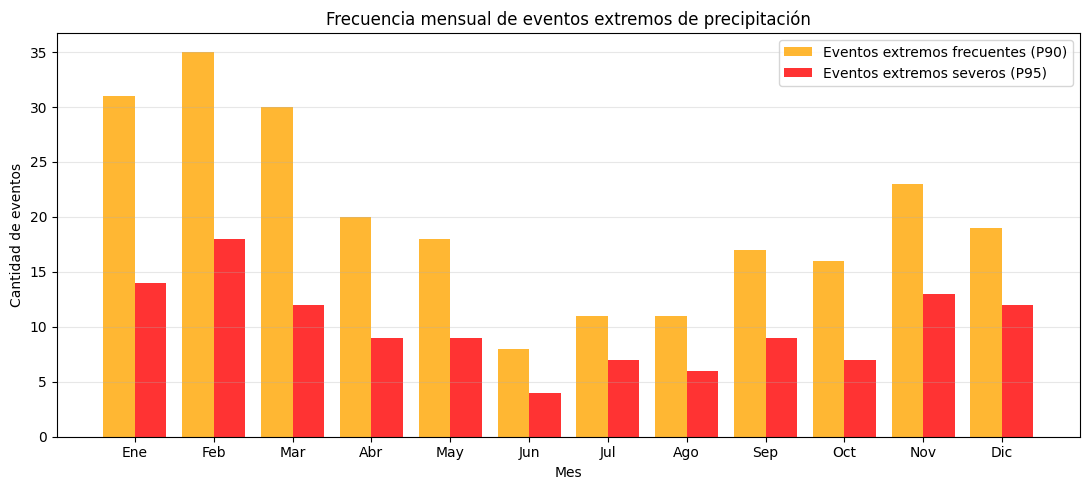

In [ ]:
# Grafico

freq_p90 = frecuencia_extremos_frecuentes_por_mes.sort_index()
freq_p95 = frecuencia_extremos_severos_por_mes.sort_index()

meses = freq_p90.index
x = np.arange(len(meses))
width = 0.4

plt.figure(figsize=(11, 5))

# P90 - frecuentes (barras naranjas)
plt.bar(
    x - width/2,
    freq_p90.values,
    width=width,
    label="Eventos extremos frecuentes (P90)",
    color="orange",
    alpha=0.8
)

# P95 - severos (barras rojas)
plt.bar(
    x + width/2,
    freq_p95.values,
    width=width,
    label="Eventos extremos severos (P95)",
    color="red",
    alpha=0.8
)


plt.xticks(
    x,
    [MESES_NOMBRE[m] for m in meses]
)

plt.xlabel("Mes")
plt.ylabel("Cantidad de eventos")
plt.title("Frecuencia mensual de eventos extremos de precipitación")

plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

Los eventos extremos de precipitación muestran una mayor ocurrencia en los meses cálidos, principalmente entre enero y marzo, con un segundo aumento hacia noviembre–diciembre. Los eventos severos (P95) siguen este patrón, aunque con menor frecuencia absoluta, mientras que durante el invierno (junio–agosto) la ocurrencia de eventos extremos es mínima.

Esta distribución sugiere que las tormentas más intensas tienden a coincidir con los períodos de mayores precipitaciones.


#### 6.2.5 Relación entre eventos extremos de precipitación y el tipo de año

En esta sección se analiza la relación entre la ocurrencia de eventos extremos de precipitación diaria y el tipo de año hidrológico (húmedo, normal o seco), previamente definido según la precipitación anual acumulada.

El objetivo es evaluar cómo se distribuyen los eventos extremos frecuentes (P90) y severos (P95) entre los distintos tipos de año.


In [ ]:
# Frecuencia anual de eventos frecuentes
frecuencia_p90_por_anio = (
    eventos_extremos_frecuentes["anio"]
    .value_counts()
    .sort_index()
)

# Frecuencia anual de eventos severos
frecuencia_p95_por_anio = (
    eventos_extremos_severos["anio"]
    .value_counts()
    .sort_index()
)

In [ ]:
# Agrupo en un df los eventos frecuentes y severos
resumen_extremos = pd.DataFrame({
    "Eventos_P90": frecuencia_p90_por_anio,
    "Eventos_P95": frecuencia_p95_por_anio
}).fillna(0).astype(int)


# Agrego el tipo de año
resumen_extremos["tipo_anio"] = "Normal"

resumen_extremos.loc[
    resumen_extremos.index.isin(anios_humedos),
    "tipo_anio"
] = "Húmedo"

resumen_extremos.loc[
    resumen_extremos.index.isin(anios_secos),
    "tipo_anio"
] = "Seco"

In [ ]:
# Agrupo por tipo de año
resumen_por_tipo_anio = (
    resumen_extremos
    .groupby("tipo_anio")[["Eventos_P90", "Eventos_P95"]]
    .sum()
)

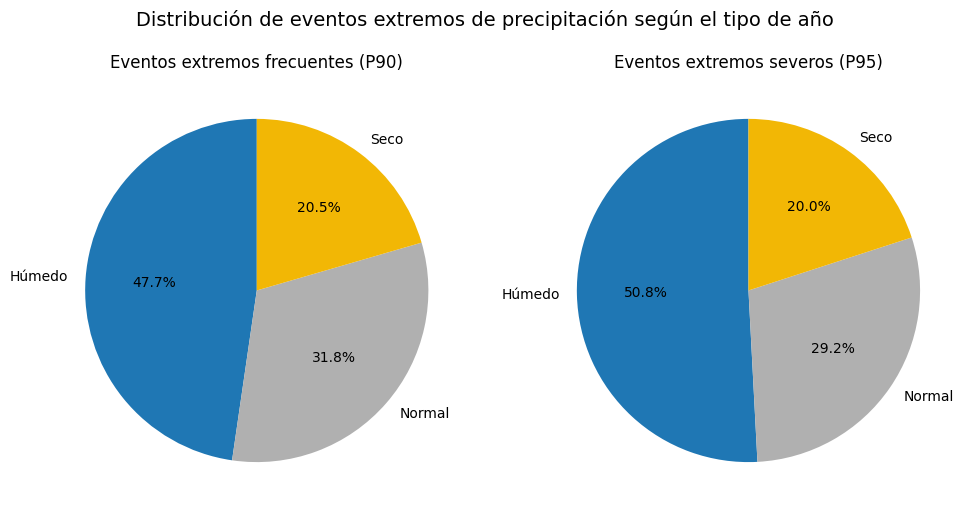

In [ ]:
# Grafico

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle(
    "Distribución de eventos extremos de precipitación según el tipo de año",
    fontsize=14,
    y=1.02
)

# Colores
colores = {
    "Húmedo": "#1f77b4",   # azul
    "Normal": "#b0b0b0",   # gris
    "Seco": "#f2b705"      # amarillo
}

# Frecuentes
axes[0].pie(
    resumen_por_tipo_anio["Eventos_P90"],
    labels=resumen_por_tipo_anio.index,
    autopct="%.1f%%",
    startangle=90,
    colors=[colores[t] for t in resumen_por_tipo_anio.index]
)
axes[0].set_title("Eventos extremos frecuentes (P90)", fontsize=12)

# Severos
axes[1].pie(
    resumen_por_tipo_anio["Eventos_P95"],
    labels=resumen_por_tipo_anio.index,
    autopct="%.1f%%",
    startangle=90,
    colors=[colores[t] for t in resumen_por_tipo_anio.index]
)
axes[1].set_title("Eventos extremos severos (P95)", fontsize=12)

plt.tight_layout()
plt.show()

La ocurrencia de eventos extremos diarios de precipitación, tanto frecuentes (P90) como severos (P95), se concentra principalmente en los años húmedos, que representan el 47,7 % de los eventos frecuentes y el 50,8 % de los severos. Los años normales muestran una participación intermedia (31,8 % y 29,2 %, respectivamente), mientras que los años secos tienen la menor proporción (21,5 % y 20 %).

A pesar de esta tendencia, la presencia de episodios intensos en años normales e incluso secos indica que las tormentas extremas no dependen exclusivamente del carácter húmedo anual.


### 6.3 Análisis exploratorio del régimen de vientos

En esta sección se analiza el comportamiento del viento registrado en la estación Aeroparque durante el período de estudio, caracterizando la velocidad escalar media, su variabilidad temporal, las direcciones predominantes y la ocurrencia de eventos de viento intenso.


#### 6.3.1 Velocidad escalar media y variabilidad temporal del viento

Se analiza la evolución temporal de la velocidad media del viento,
con el objetivo de identificar patrones de variabilidad, tendencias
y posibles cambios en el comportamiento a lo largo del período analizado.

In [ ]:
# Los valores iguales a 0 indican ausencia de dato, por lo que se
# reemplazan por NaN para evitar que influyan en el cálculo de valores medios.

df_clima["viento_escalar_medio_kmh"] = df_clima[
    "viento_escalar_medio_kmh"
].replace(0, np.nan)

In [ ]:
# Cálculo de la velocidad escalar media del viento para todo el período de estudio (2002–2022)

viento_medio_periodo = (
    df_clima["viento_escalar_medio_kmh"]
    .mean()
    .round(1)
)

In [ ]:
# Cálculo de la velocidad escalar media mensual

viento_medio_mensual = (
    df_clima
    .groupby("mes")["viento_escalar_medio_kmh"]
    .mean()
    .round(1)
)

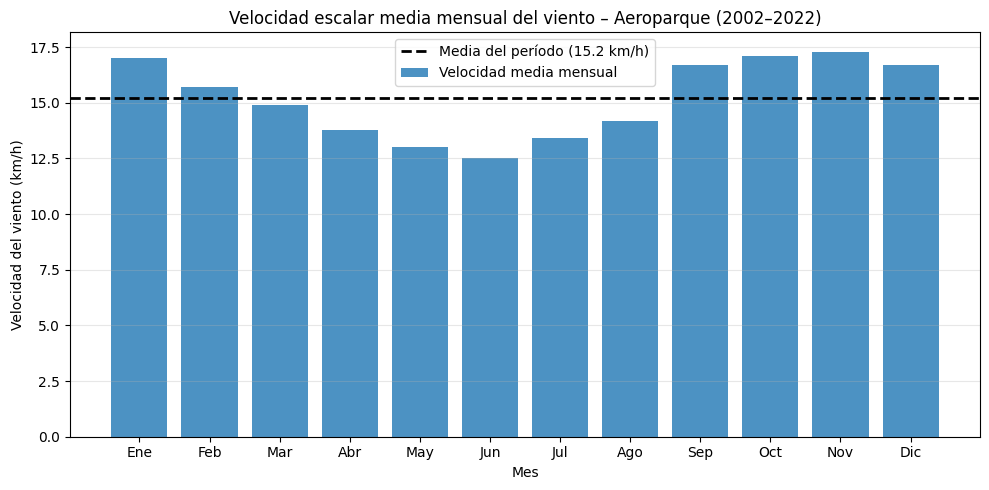

In [ ]:
# Grafico

plt.figure(figsize=(10, 5))

# Barras: velocidad media mensual del viento
plt.bar(
    viento_medio_mensual.index,
    viento_medio_mensual.values,
    alpha=0.8,
    label="Velocidad media mensual"
)

# Línea horizontal: velocidad media del período completo
plt.axhline(
    viento_medio_periodo,
    linestyle="--",
    linewidth=2,
    color="black",
    label=f"Media del período ({viento_medio_periodo} km/h)"
)

plt.xlabel("Mes")
plt.ylabel("Velocidad del viento (km/h)")
plt.title("Velocidad escalar media mensual del viento – Aeroparque (2002–2022)")

plt.xticks(
    viento_medio_mensual.index,
    [MESES_NOMBRE[m] for m in viento_medio_mensual.index]
)

plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

La serie temporal de la velocidad escalar media mensual del viento (2002–2022) muestra una variabilidad moderada, con una velocidad promedio de aproximadamente 15,2 km/h que sirve como referencia para analizar la estacionalidad.

Las velocidades mínimas se registran en invierno, especialmente en mayo y junio (<13 km/h), mientras que los valores máximos ocurren durante la primavera y comienzos del verano, entre septiembre y noviembre, superando los 17 km/h.


#### 6.3.2 Análisis de direcciones predominantes del viento

Se analiza la distribución de direcciones del viento a partir de los vientos máximos diarios, calculando su frecuencia relativa. El objetivo es identificar los sectores dominantes y aquellos asociados a los eventos más intensos, así como evaluar la estabilidad de estos patrones a lo largo del período analizado.

In [ ]:
# Preparación del dataframe para el análisis de viento

df_viento = df_clima.copy()

In [ ]:
# Definición de clases de velocidad máxima diaria (km/h)
# Intervalos fijos con fines descriptivos

bins_vel = [
    0,
    20,
    40,
    60,
    df_viento["viento_max_kmh"].max()
]

labels_vel = ["0–20", "20–40", "40–60", ">60"]

In [ ]:
# Clasifico cada registro según clase de velocidad máxima diaria

df_viento["clase_vel"] = pd.cut(
    df_viento["viento_max_kmh"],
    bins=bins_vel,
    labels=labels_vel,
    right=False
)

In [ ]:
# Conteo conjunto por dirección del viento y clase de velocidad

tabla_rosa = (
    df_viento
    .groupby(["direccion_viento", "clase_vel"])
    .size()
    .unstack(fill_value=0)
)

/tmp/ipython-input-1574286994.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["direccion_viento", "clase_vel"])


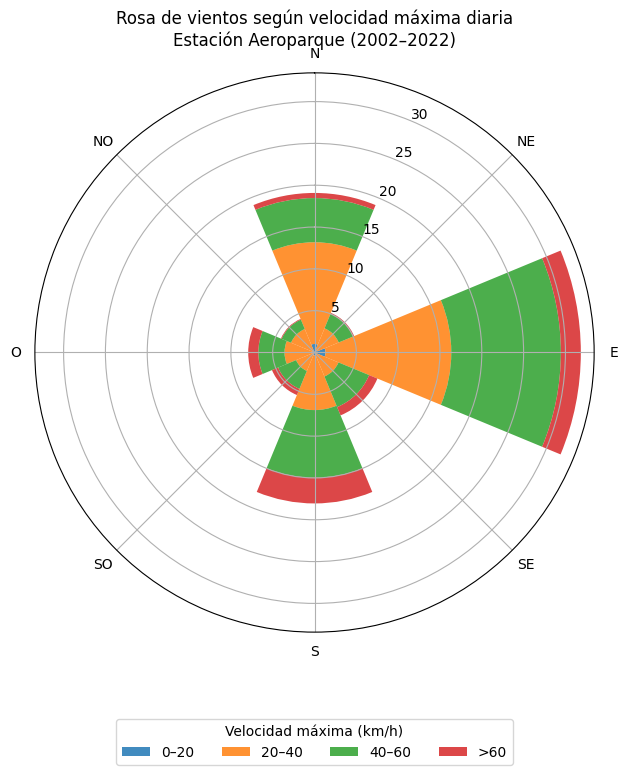

In [ ]:
# Grafico

# Reordenamiento y conversión a porcentaje

orden_direcciones = [
    "Norte", "Noreste", "Este", "Sudeste",
    "Sur", "Sudoeste", "Oeste", "Noroeste"
]

tabla_rosa = tabla_rosa.reindex(orden_direcciones)

tabla_rosa_pct = tabla_rosa / tabla_rosa.sum().sum() * 100

# Construcción de la rosa de vientos

angulos = np.linspace(
    0,
    2 * np.pi,
    len(tabla_rosa_pct),
    endpoint=False
)

fig, ax = plt.subplots(
    figsize=(8, 8),
    subplot_kw=dict(polar=True)
)

bottom = np.zeros(len(tabla_rosa_pct))

for clase in labels_vel:
    valores = tabla_rosa_pct[clase].values
    ax.bar(
        angulos,
        valores,
        bottom=bottom,
        width=2 * np.pi / len(tabla_rosa_pct),
        label=clase,
        alpha=0.85
    )
    bottom += valores

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.set_thetagrids(
    np.degrees(angulos),
    labels=["N", "NE", "E", "SE", "S", "SO", "O", "NO"]
)

ax.set_title(
    "Rosa de vientos según velocidad máxima diaria\n"
    "Estación Aeroparque (2002–2022)",
    pad=20
)

ax.legend(
    title="Velocidad máxima (km/h)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=4
)

plt.tight_layout()
plt.show()

Las direcciones predominantes de viento máximo durante el período fueron Este, Norte y Sur, siendo el Este la más frecuente. Aunque la mayoría de los registros provienen del Este, los vientos del Sur, Sudeste y Sudoeste concentran una proporción significativa de los eventos más intensos.

El cuadrante Norte es abundante pero se caracteriza principalmente por vientos de baja a moderada intensidad, mientras que los vientos del Oeste tienen una participación menor en el régimen general. En conjunto, la rosa de vientos evidencia que los sectores dominantes y los más energéticos no coinciden, lo que es clave para interpretar la dinámica atmosférica en la región.

#### 6.3.3 Dirección del viento y velocidades máximas

Se analizan los valores de velocidad máxima diaria del viento segmentados por dirección, con el objetivo de identificar qué orientaciones concentran los vientos más intensos a lo largo del período.

In [ ]:
# Velocidad máxima media del viento por dirección (promedio de los valores máximos diarios)
vel_max_media_por_dir = (
    df_clima
    .groupby("direccion_viento")["viento_max_kmh"]
    .mean()
    .sort_values(ascending=False)
    .round(1)
)

In [ ]:
# Percentiles elevados de la velocidad máxima diaria del viento por dirección
# Se calculan sobre la variable viento_max_kmh (máximo diario registrado),

p90_viento_max_por_dir = (
    df_clima
    .groupby("direccion_viento")["viento_max_kmh"]
    .quantile(0.90)
    .round(1)
)

p95_viento_max_por_dir = (
    df_clima
    .groupby("direccion_viento")["viento_max_kmh"]
    .quantile(0.95)
    .round(1)
)

In [ ]:
# Tabla resumen de velocidades máximas del viento por dirección
tabla_viento_max = (
    pd.DataFrame({
        "Velocidad máxima media (km/h)": vel_max_media_por_dir,
        "P90 velocidad máxima (km/h)": p90_viento_max_por_dir,
        "P95 velocidad máxima (km/h)": p95_viento_max_por_dir
    })
    .sort_values("Velocidad máxima media (km/h)", ascending=False)
)

tabla_viento_max

,Velocidad máxima media (km/h),P90 velocidad máxima (km/h),P95 velocidad máxima (km/h)
direccion_viento,,,
Sur,45.8,67.0,74.0
Sudeste,44.6,65.0,67.9
Sudoeste,44.0,65.0,70.0
Oeste,43.9,65.0,72.0
Este,40.4,57.0,65.0
Noreste,36.2,52.0,57.0
Norte,35.6,50.0,56.0
Noroeste,35.5,48.0,54.7


La velocidad máxima diaria del viento depende claramente de la dirección. Los mayores valores promedio se registran en los sectores Sur, Sudeste y Sudoeste, mientras que el Oeste, aunque es poco frecuente, también alcanza velocidades máximas elevadas. Las direcciones del cuadrante Norte presentan intensidades menores.

Aunque la dirección Este es la más frecuente, sus valores máximos son inferiores a los del Sur, Sudeste, Sudoeste y Oeste. Esto indica que los vientos más fuertes no coinciden necesariamente con las direcciones predominantes.

#### 6.3.4 Eventos extremos de viento según dirección

En esta sección se analizan los eventos extremos de viento según su dirección, con el objetivo de identificar los sectores que concentran los episodios de mayor intensidad.  

Los eventos se definen a partir de percentiles elevados de la velocidad máxima diaria: el **percentil 90 (P90)** representa eventos extremos frecuentes y el **percentil 95 (P95)** eventos extremos severos.

In [ ]:
# Defino los umbrales

# P95 para eventos extremos severos
umbral_viento_p95 = df_clima["viento_max_kmh"].quantile(0.95)

# P90 para eventos extremos frecuentes
umbral_viento_p90 = df_clima["viento_max_kmh"].quantile(0.90)

In [ ]:
# Eventos severos
eventos_viento_p95 = df_clima[
    df_clima["viento_max_kmh"] >= umbral_viento_p95
]

# Eventos frecuentes
eventos_viento_p90 = df_clima[
    df_clima["viento_max_kmh"] >= umbral_viento_p90
]

In [ ]:
# Calculo la frecuencia por direccion

# Severos
frecuencia_viento_p95_por_dir = (
    eventos_viento_p95["direccion_viento"]
    .value_counts()
)

# Frecuentes
frecuencia_viento_p90_por_dir = (
    eventos_viento_p90["direccion_viento"]
    .value_counts()
)

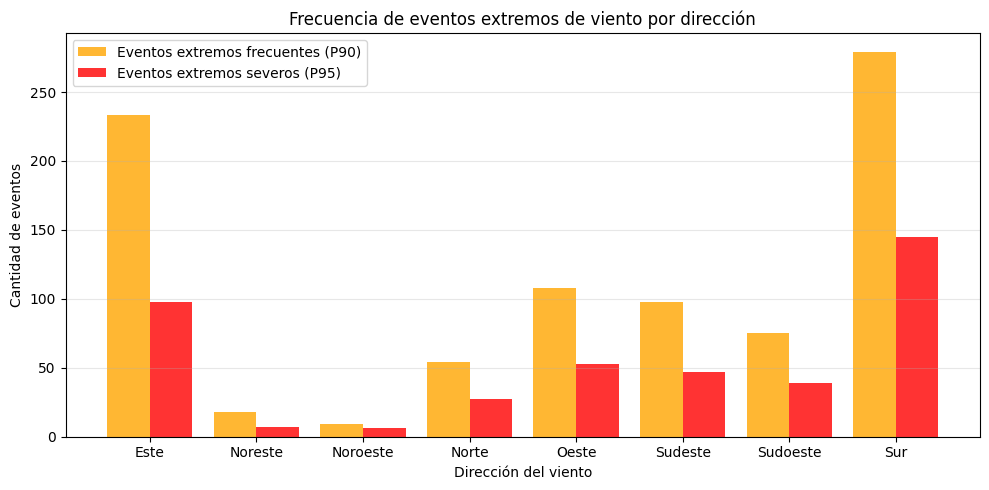

In [ ]:
# Grafico

# Ordenamos direcciones según P90
freq_p90_dir = frecuencia_viento_p90_por_dir.sort_index()
freq_p95_dir = frecuencia_viento_p95_por_dir.reindex(freq_p90_dir.index).fillna(0)

direcciones = freq_p90_dir.index
x = np.arange(len(direcciones))
width = 0.4

plt.figure(figsize=(10, 5))

# Eventos frecuentes (P90) - Barras naranjas
plt.bar(
    x - width/2,
    freq_p90_dir.values,
    width=width,
    label="Eventos extremos frecuentes (P90)",
    color="orange",
    alpha=0.8
)

# Eventos severos (P95) - Barras rojas
plt.bar(
    x + width/2,
    freq_p95_dir.values,
    width=width,
    label="Eventos extremos severos (P95)",
    color="red",
    alpha=0.8
)

plt.xticks(x, direcciones)
plt.xlabel("Dirección del viento")
plt.ylabel("Cantidad de eventos")
plt.title("Frecuencia de eventos extremos de viento por dirección")

plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

La distribución direccional de los eventos extremos de viento evidencia un predominio del cuadrante Sur (Sur, Sudeste y Sudoeste), tanto para eventos frecuentes (P90) como para los severos (P95). La dirección Sur concentra la mayor cantidad de registros individuales, mientras que Sudeste y Sudoeste refuerzan la dominancia de este cuadrante en la ocurrencia de vientos extremos.

Aunque algunas direcciones, como el Este, presentan alta frecuencia, los episodios de mayor intensidad se asocian principalmente a flujos provenientes del cuadrante Sur. Esto es consistente con los valores más elevados de velocidad máxima media y percentiles extremos registrados para estas direcciones.



#### 6.3.5 Comparación temporal del viento: primeros vs últimos 10 años

A continuación, se compara el régimen de vientos entre los primeros (Periodo A) y los últimos diez años (Periodo B) del registro, analizando cambios en la frecuencia direccional y en la distribución de eventos extremos frecuentes y severos para identificar posibles modificaciones temporales en la dinámica del viento.

In [ ]:
# Defino el periodo, primeros 10 años (Periodo A) vs ultimos 10 años (Periodo B)

anios_ordenados = sorted(df_clima["anio"].unique())

primeros_10 = anios_ordenados[:10]
ultimos_10 = anios_ordenados[-10:]

df_viento_1 = df_clima[df_clima["anio"].isin(primeros_10)].copy()
df_viento_2 = df_clima[df_clima["anio"].isin(ultimos_10)].copy()

In [ ]:
# Primeros 10 (Periodo A)
dir_freq_1 = (
    df_viento_1["direccion_viento"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
)

# Ultimos 10 (Periodo B)
dir_freq_2 = (
    df_viento_2["direccion_viento"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
)

In [ ]:
# Vel maxima media por direcion
# Primeros 10
vel_max_media_dir_1 = (
    df_viento_1
    .groupby("direccion_viento")["viento_max_kmh"]
    .mean()
    .round(1)
)

# Ultimos 10
vel_max_media_dir_2 = (
    df_viento_2
    .groupby("direccion_viento")["viento_max_kmh"]
    .mean()
    .round(1)
)

In [ ]:
# Eventos extremos con p95
umbral_p95_viento = df_clima["viento_max_kmh"].quantile(0.95)

# Primeros 10
extremos_1 = df_viento_1[df_viento_1["viento_max_kmh"] >= umbral_p95_viento]

dir_p95_1 = (
    extremos_1["direccion_viento"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
)

# Ultimos 10
extremos_2 = df_viento_2[df_viento_2["viento_max_kmh"] >= umbral_p95_viento]

dir_p95_2 = (
    extremos_2["direccion_viento"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
)


In [ ]:
comparacion_viento = (
    pd.concat(
        [
            dir_freq_1.rename("Frecuencia % Periodo A"),
            dir_freq_2.rename("Frecuencia % Periodo B"),
            vel_max_media_dir_1.rename("Velocidad máxima media Periodo A"),
            vel_max_media_dir_2.rename("Velocidad máxima media Periodo B"),
            dir_p95_1.rename("P95 % Periodo A"),
            dir_p95_2.rename("P95 % Periodo B"),
        ],
        axis=1
    )
    .fillna(0)
)

comparacion_viento

,Frecuencia % Periodo A,Frecuencia % Periodo B,Velocidad máxima media Periodo A,Velocidad máxima media Periodo B,P95 % Periodo A,P95 % Periodo B
direccion_viento,,,,,,
Este,31.2,32.7,44.1,36.5,22.8,27.1
Sur,18.9,16.1,50.0,40.0,36.7,19.6
Norte,18.3,19.2,38.5,32.5,7.5,4.7
Sudeste,8.9,8.2,48.3,40.6,13.5,8.4
Oeste,7.7,7.6,46.8,40.5,10.0,17.8
Sudoeste,5.9,5.5,47.3,40.3,8.5,13.1
Noreste,4.6,6.1,39.4,33.8,0.4,5.6
Noroeste,4.4,4.6,36.6,34.3,0.7,3.7


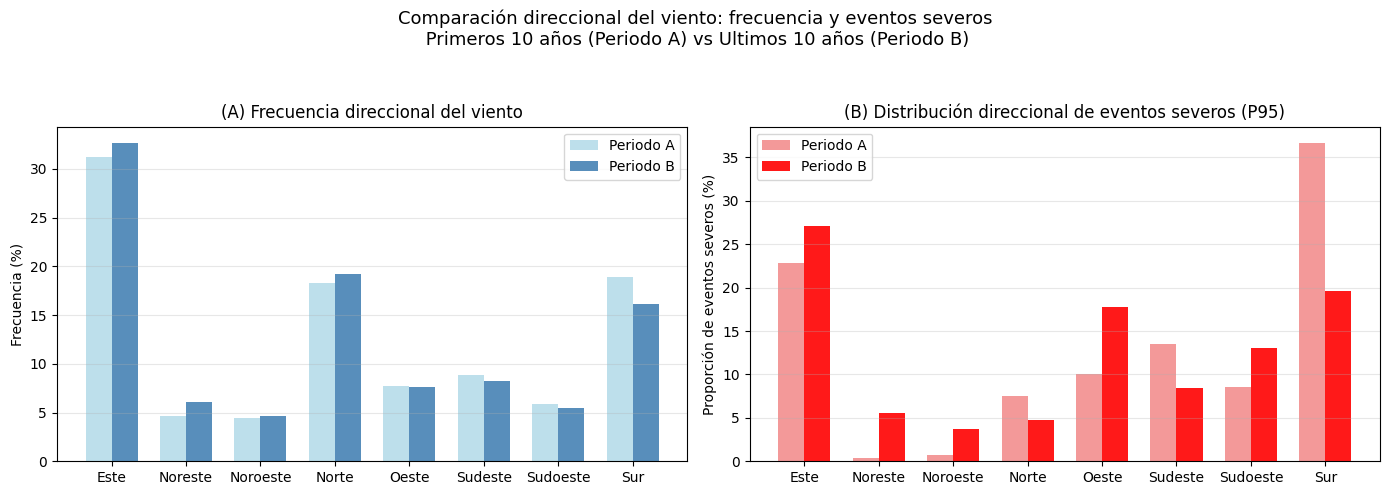

In [ ]:
# Orden (similar a graficos anteriores)
orden_dir = frecuencia_viento_p90_por_dir.sort_index().index

# Datos
freq_A = comparacion_viento.loc[orden_dir, "Frecuencia % Periodo A"]
freq_B = comparacion_viento.loc[orden_dir, "Frecuencia % Periodo B"]

p95_A = comparacion_viento.loc[orden_dir, "P95 % Periodo A"]
p95_B = comparacion_viento.loc[orden_dir, "P95 % Periodo B"]

# Posiciones eje x
x = np.arange(len(orden_dir))
width = 0.35

# Grafico
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)


# (A) Frecuencia direccional

axes[0].bar(
    x - width/2, freq_A.values, width,
    label="Periodo A",
    color="lightblue", alpha=0.8
)

axes[0].bar(
    x + width/2, freq_B.values, width,
    label="Periodo B",
    color="steelblue", alpha=0.9
)

axes[0].set_ylabel("Frecuencia (%)")
axes[0].set_title("(A) Frecuencia direccional del viento")
axes[0].set_xticks(x)
axes[0].set_xticklabels(orden_dir)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend()


# (B) Eventos severos (P95)

axes[1].bar(
    x - width/2, p95_A.values, width,
    label="Periodo A",
    color="lightcoral", alpha=0.8
)

axes[1].bar(
    x + width/2, p95_B.values, width,
    label="Periodo B",
    color="red", alpha=0.9
)

axes[1].set_ylabel("Proporción de eventos severos (%)")
axes[1].set_title("(B) Distribución direccional de eventos severos (P95)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(orden_dir)
axes[1].grid(axis="y", alpha=0.3)
axes[1].legend()


plt.suptitle(
    "Comparación direccional del viento: frecuencia y eventos severos\n Primeros 10 años (Periodo A) vs Ultimos 10 años (Periodo B)",
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

El análisis comparativo entre los primeros y últimos diez años del registro muestra cambios en la distribución direccional y en la severidad de los vientos.

La frecuencia direccional se mantiene dominada por los vientos del Este, del Norte y del Sur en ambos períodos. Aunque se observa una ligera disminución del cuadrante Sur y un ligero aumento de los vientos del Norte.

En cuanto a los eventos severos (P95), se registra una importante reducción de la proporción de eventos asociados al Sur, acompañada por un aumento relativo en los cuadrantes Norte, Este y sobre todo del Oeste. Esto indica que, aunque los vientos del Sur siguen presentes, su contribución a los episodios más intensos ha disminuido en el período reciente.



### 6.4 Síntesis de resultado

#### 6.4.1 Sintesis de precipitaciones

El siguiente cuadro sintetiza los principales resultados del análisis de la precipitación, integrando valores medios, extremos y eventos intensos del período estudiado.

/tmp/ipython-input-2412032992.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


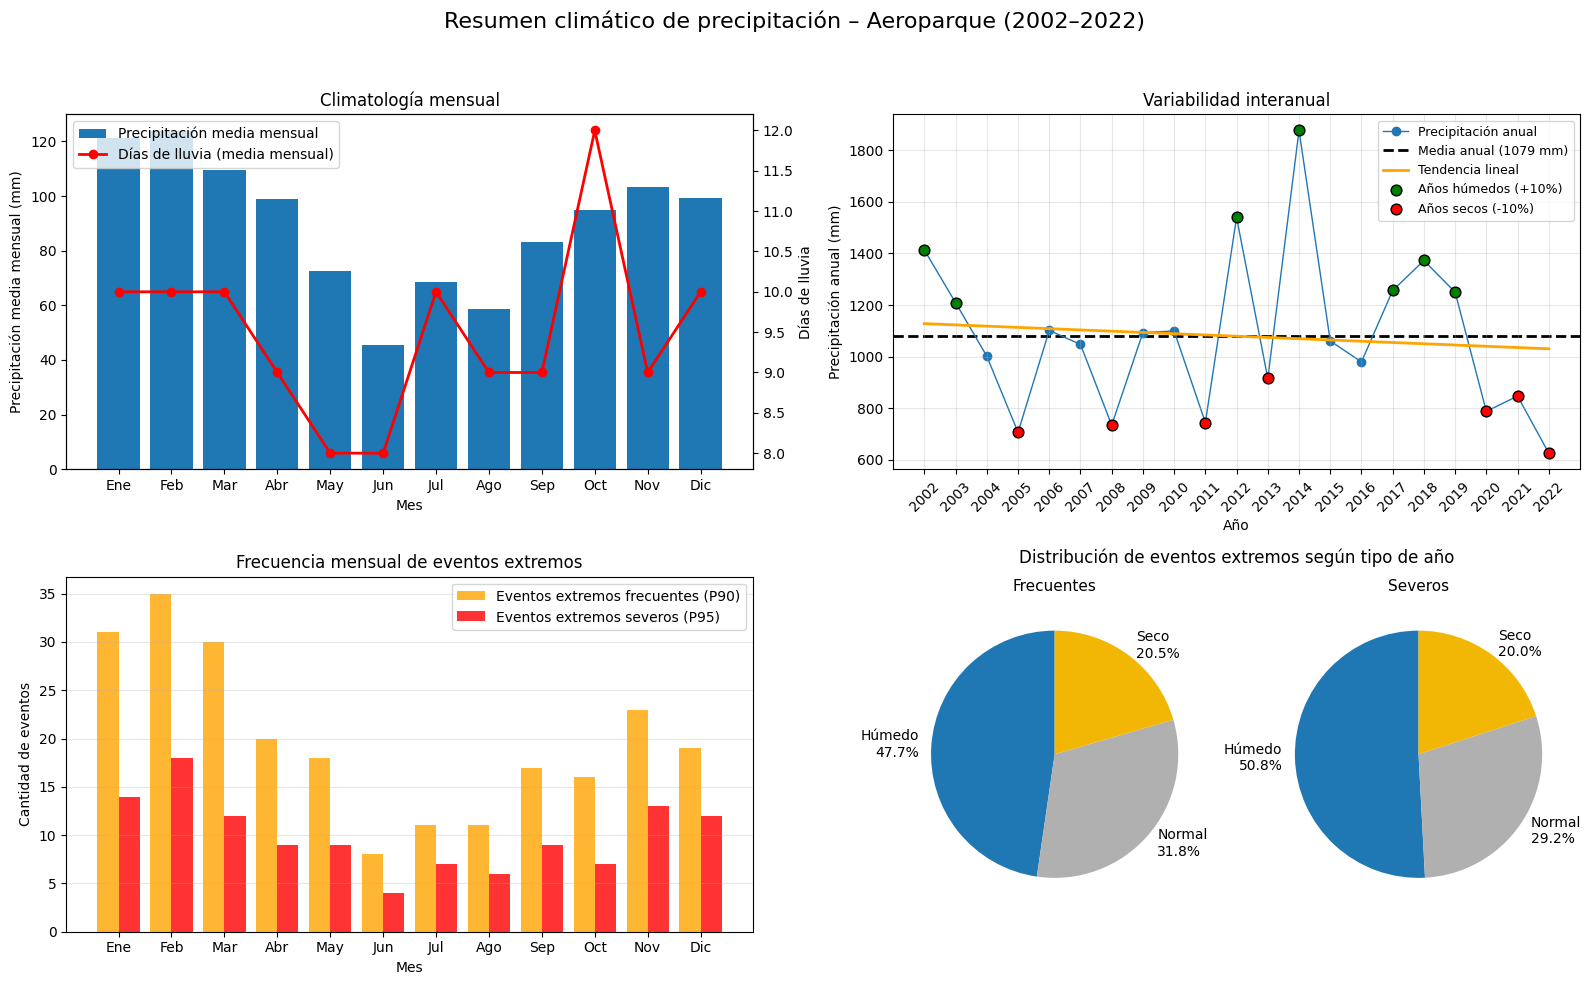

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(
    "Resumen climático de precipitación – Aeroparque (2002–2022)",
    fontsize=16,
    y=0.98
)

# ============================================================
# (A) PPIT media mensual + días de lluvia
# ============================================================

ax1 = axes[0, 0]

ax1.bar(
    ppit_media_mensual.index,
    ppit_media_mensual.values,
    label="Precipitación media mensual",
    zorder=1
)
ax1.set_ylabel("Precipitación media mensual (mm)")
ax1.set_xlabel("Mes")


ax1b = ax1.twinx()
ax1b.plot(
    dias_lluvia_media_mensual.index,
    dias_lluvia_media_mensual.values,
    color="red",
    marker="o",
    linewidth=2,
    label="Días de lluvia (media mensual)",
    zorder=3
)
ax1b.set_ylabel("Días de lluvia")

ax1.set_xticks(ppit_media_mensual.index)
ax1.set_xticklabels(
    [MESES_NOMBRE[m] for m in ppit_media_mensual.index]
)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax1b.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

ax1.set_title("Climatología mensual")

# ============================================================
# (B) Variabilidad interanual
# ============================================================

ax2 = axes[0, 1]

ax2.plot(
    anios,
    ppit_anual,
    marker="o",
    linewidth=1,
    label="Precipitación anual",
    zorder=1
)

ax2.axhline(
    ppit_media_anual,
    linestyle="--",
    linewidth=2,
    color="black",
    label=f"Media anual ({ppit_media_anual:.0f} mm)",
    zorder=0
)

ax2.plot(
    anios,
    ppit_tendencia,
    linewidth=2,
    color="orange",
    label="Tendencia lineal",
    zorder=2
)

ax2.scatter(
    anios_humedos,
    ppit_humedos,
    color="green",
    edgecolor="black",
    s=60,
    label="Años húmedos (+10%)",
    zorder=3
)

ax2.scatter(
    anios_secos,
    ppit_secos,
    color="red",
    edgecolor="black",
    s=60,
    label="Años secos (-10%)",
    zorder=3
)

ax2.set_xticks(anios)
ax2.set_xticklabels(anios, rotation=45)
ax2.set_xlabel("Año")
ax2.set_ylabel("Precipitación anual (mm)")
ax2.set_title("Variabilidad interanual")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)


# ============================================================
# (C) Frecuencia mensual de extremos
# ============================================================

ax3 = axes[1, 0]

freq_p90 = frecuencia_extremos_frecuentes_por_mes.sort_index()
freq_p95 = frecuencia_extremos_severos_por_mes.sort_index()

meses = freq_p90.index
x = np.arange(len(meses))
width = 0.4

ax3.bar(
    x - width/2,
    freq_p90.values,
    width=width,
    label="Eventos extremos frecuentes (P90)",
    color="orange",
    alpha=0.8
)

ax3.bar(
    x + width/2,
    freq_p95.values,
    width=width,
    label="Eventos extremos severos (P95)",
    color="red",
    alpha=0.8
)

ax3.set_xticks(x)
ax3.set_xticklabels(
    [MESES_NOMBRE[m] for m in meses]
)
ax3.set_xlabel("Mes")
ax3.set_ylabel("Cantidad de eventos")
ax3.set_title("Frecuencia mensual de eventos extremos")
ax3.legend()
ax3.grid(axis="y", alpha=0.3)


# ============================================================
# (D) Extremos segun tipo de año
# ============================================================

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax4 = axes[1, 1]
ax4.axis("off")

colores = {
    "Húmedo": "#1f77b4",
    "Normal": "#b0b0b0",
    "Seco": "#f2b705"
}

resumen_por_tipo_anio = (
    resumen_extremos
    .groupby("tipo_anio")[["Eventos_P90", "Eventos_P95"]]
    .sum()
)

# Frecuentes (p90)
ax_p90 = inset_axes(
    ax4,
    width="45%",
    height="90%",
    loc="center left"
)

ax_p90.pie(
    resumen_por_tipo_anio["Eventos_P90"],
    labels=[
        f"{t}\n{v / resumen_por_tipo_anio['Eventos_P90'].sum() * 100:.1f}%"
        for t, v in resumen_por_tipo_anio["Eventos_P90"].items()
    ],
    startangle=90,
    colors=[colores[t] for t in resumen_por_tipo_anio.index]
)
ax_p90.set_title("Frecuentes", fontsize=11)
ax_p90.set_aspect("equal")


# Severos (p95)
ax_p95 = inset_axes(
    ax4,
    width="45%",
    height="90%",
    loc="center right"
)

ax_p95.pie(
    resumen_por_tipo_anio["Eventos_P95"],
    labels=[
        f"{t}\n{v / resumen_por_tipo_anio['Eventos_P95'].sum() * 100:.1f}%"
        for t, v in resumen_por_tipo_anio["Eventos_P95"].items()
    ],
    startangle=90,
    colors=[colores[t] for t in resumen_por_tipo_anio.index]
)
ax_p95.set_title("Severos", fontsize=11)
ax_p95.set_aspect("equal")

ax4.set_title(
    "Distribución de eventos extremos según tipo de año",
    fontsize=12,
    pad=10
)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

El análisis de precipitación en la estación Aeroparque (2002 - 2022) evidencia un régimen estacional marcado, con máximos durante los meses cálidos y mínimos en invierno, así como variabilidad interanual significativa.  

Si bien la precipitación media anual se mantiene relativamente estable, se observan alternancias entre años húmedos y secos, con una ligera tendencia hacia condiciones más secas en los años recientes.  

Los eventos de precipitación extrema muestran fuerte estacionalidad y predominan en años húmedos, aunque también ocurren en años normales y secos, indicando que las tormentas más intensas responden a procesos atmosféricos de corta duración que no siempre se reflejan en los totales anuales.

#### 6.4.2 Sintesis de vientos

El siguiente cuadro sintetiza los principales resultados del análisis del viento, integrando velocidades medias, direcciones predominantes y la ocurrencia de eventos extremos del período estudiado.

/tmp/ipython-input-340726705.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


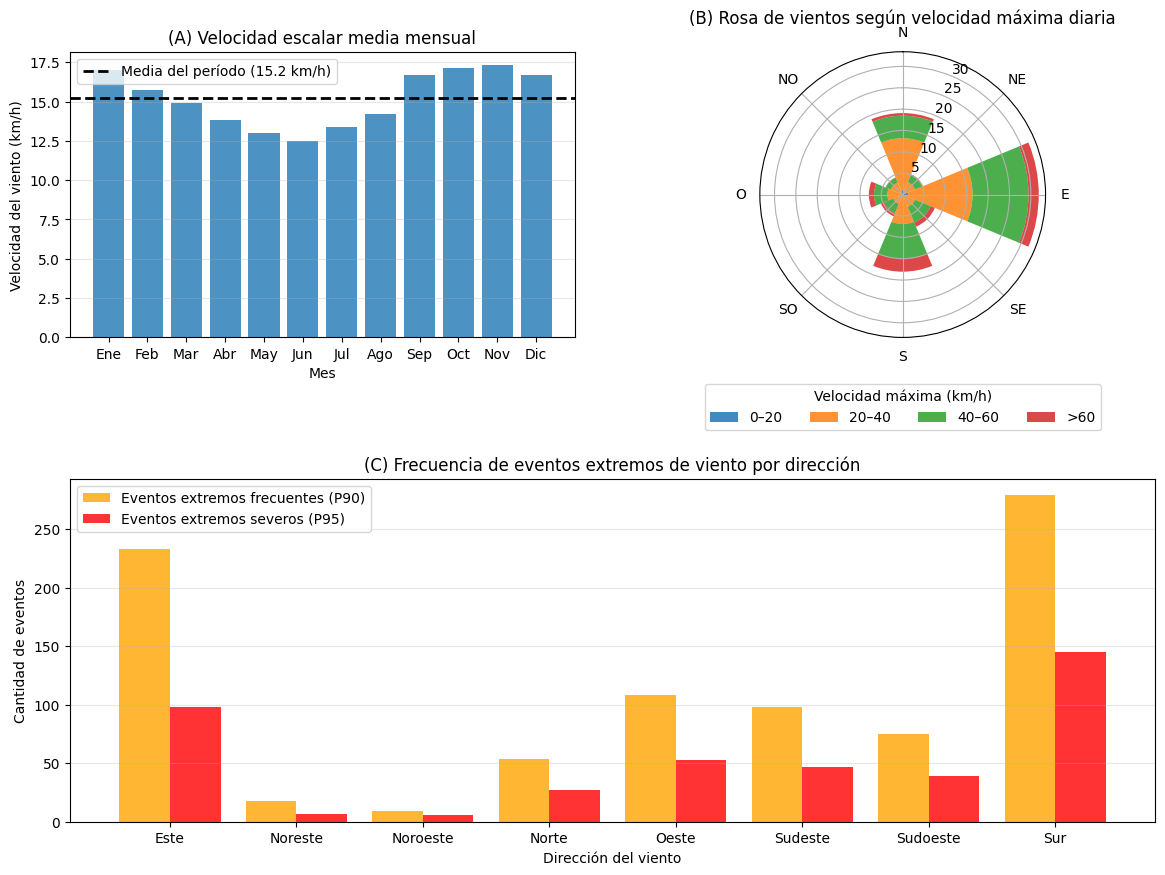

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(
    2, 2,
    height_ratios=[1, 1.2],
    hspace=0.45,
    wspace=0.15
)

# ------------------------------------------------------------
# Velocidad escalar media mensual
# ------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

ax1.bar(
    viento_medio_mensual.index,
    viento_medio_mensual.values,
    alpha=0.8
)

ax1.axhline(
    viento_medio_periodo,
    linestyle="--",
    linewidth=2,
    color="black",
    label=f"Media del período ({viento_medio_periodo} km/h)"
)

ax1.set_xlabel("Mes")
ax1.set_ylabel("Velocidad del viento (km/h)")
ax1.set_title("(A) Velocidad escalar media mensual")

ax1.set_xticks(viento_medio_mensual.index)
ax1.set_xticklabels([MESES_NOMBRE[m] for m in viento_medio_mensual.index])

ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# ------------------------------------------------------------
# Rosa de vientos
# ------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1], polar=True)

bottom = np.zeros(len(tabla_rosa_pct))

for clase in labels_vel:
    valores = tabla_rosa_pct[clase].values
    ax2.bar(
        angulos,
        valores,
        bottom=bottom,
        width=2 * np.pi / len(tabla_rosa_pct),
        label=clase,
        alpha=0.85
    )
    bottom += valores

ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)

ax2.set_thetagrids(
    np.degrees(angulos),
    labels=["N", "NE", "E", "SE", "S", "SO", "O", "NO"]
)

ax2.set_title("(B) Rosa de vientos según velocidad máxima diaria", pad=20)

ax2.legend(
    title="Velocidad máxima (km/h)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.35),
    ncol=4,
)

# ------------------------------------------------------------
# Eventos extremos por dirección
# ------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])

direcciones = freq_p90_dir.index
x = np.arange(len(direcciones))
width = 0.4

ax3.bar(
    x - width/2,
    freq_p90_dir.values,
    width=width,
    label="Eventos extremos frecuentes (P90)",
    color="orange",
    alpha=0.8
)

ax3.bar(
    x + width/2,
    freq_p95_dir.values,
    width=width,
    label="Eventos extremos severos (P95)",
    color="red",
    alpha=0.8
)

ax3.set_xticks(x)
ax3.set_xticklabels(direcciones)
ax3.set_xlabel("Dirección del viento")
ax3.set_ylabel("Cantidad de eventos")
ax3.set_title("(C) Frecuencia de eventos extremos de viento por dirección")

ax3.legend()
ax3.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

La velocidad media del viento muestra un patrón claro a lo largo del año, con valores más bajos en invierno y mayores en primavera y verano, reflejando la mayor energía del viento en los meses cálidos.

En general, predominan los vientos del Este. Sin embargo, los vientos más fuertes suelen provenir del Sur, especialmente los eventos extremos (P90 y P95). Esto muestra que los episodios más intensos no siempre coinciden con la dirección más frecuente.

Comparando los primeros y últimos diez años del registro, se observan cambios sutiles: los vientos del Sur son algo menos frecuentes y los extremos de otros cuadrantes (Norte, Este y Oeste) aumentan ligeramente, mientras que la tendencia general se mantiene.

## 7) Consideración final

En este proyecto se trabajo con datos climáticos históricos de Aeroparque, utilizando Python y bibliotecas científicas para explorar y visualizar patrones de precipitación y viento.

El análisis es **básico y exploratorio**, y no incluye modelos complejos ni estudios de procesos, pero sirve como un **ejemplo práctico de cómo se puede abordar un conjunto de datos climáticos**. La forma en que se organizó la información y se aplicaron las herramientas permite ver cómo se puede explorar y presentar este tipo de datos de manera rapida y reproducible.  

Más allá del análisis específico, este proyecto demuestra **habilidades en procesamiento de datos, visualización y organización de resultados**, y funciona como un **punto de partida para aplicar este tipo de análisis a otros fenómenos**, ya sea en clima, medio ambiente, riesgos, hidrodinámica u otros contextos.  
